<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/tempMaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up environment

In [ ]:
!pip install cfgrib
!pip install cartopy

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
from datetime import datetime as dt
import cfgrib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#User parameters

In [ ]:
name = "Milton"
tcNum = "14"
trackType = ""

initTime = dt(year=2024, month=10, day=7, hour=12) #Time when Milton began its most rapid intensification

fHourStep = 12      #Normally 3 for HAFS-A
forecastLength = 48 #Normally 126 for HAFS-A.
#runStep = 6         #Normally 6 for HAFS-A

figureSuffix = "_RI"
subfolder = "RI/"
dataPath = "/content/drive/MyDrive/savedData/"
figurePath = "/content/drive/MyDrive/figures/"

potentialTemp = True #Use atmospheric potential temperature instead of in-situ temperature

#Layers to plot
atmLayer = 700.0
oceLayer = 12.8

Get ATCF data and find interested point

#Retrieve HAFS-A Data

Find times needed

In [ ]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

fcastTimes = [] #Key: initiation, item: valid time list
fhour = 0
validTime = initTime

while fhour <= forecastLength:
    fcastTimes.append(validTime)
    validTime += pd.Timedelta(hours=fHourStep)
    fhour += fHourStep

Find storm location in HAFS-A from ATCF files. Used to find along-storm profile.

In [ ]:
cols = ["BASIN", "CY", "YYYYMMDDHH", "TECHNUM/MIN", "TECH", "TAU", "LatN/S", "LonE/W",
    "VMAX", "MSLP", "TY", "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
    "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION", "MAXSEAS", "INITIALS",
    "DIR", "SPEED", "STORMNAME", "DEPTH", "SEAS", "SEASCODE", "SEAS1", "SEAS2",
    "SEAS3", "SEAS4", "USERDEFINED1", "Thermo1", "Thermo2", "Thermo3", "Thermo4",
    "Thermo5", "Thermo6", "Thermo7", "USERDEFINED2", "DT", "SHR82", "SHR81_1",
    "SHR82_2",  "USERDEFINED3", "SST", "USERDEFINED4", "ARMW1", "ARMW2"]

initStr, initHour = initTime.strftime("%Y%m%d_%H").split("_")

atcfURL = f"https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/{initStr}/{initHour}/{tcNum}l.{initStr}{initHour}.hfsa.trak.atcfunix"
atcfFile = "atcf_" + initStr + "_" + initHour + ".csv"

!wget -O {atcfFile} {atcfURL}
atcf = pd.read_csv(atcfFile, names=cols)

In [ ]:
tcLocs = {}

for valid in fcastTimes:
    fHour = int((valid-initTime).total_seconds() / 3600)

    pointLat = int(atcf[atcf.TAU==fHour]["LatN/S"].iloc[0].replace("N", ""))/10
    pointLon = int(atcf[atcf.TAU==fHour]["LonE/W"].iloc[0].replace("W", ""))/-10 #Assume western hemisphere
    tcLocs[valid] = (pointLat, pointLon)

In [ ]:
tcLocs

#Figures

In [ ]:
lonMin, lonMax, latMin, latMax = -94, -86, 21, 27

In [ ]:
atmLayers = [0, 2, 4, 6, 8, 10]
oceLayers = [0, 2, 4, 6, 8, 10]

In [ ]:
#atmLayer = atmData.isobaricInhPa.data[abs(atmData.isobaricInhPa.data-atmLayer)==min(abs(atmData.isobaricInhPa.data-atmLayer))][0]
#oceLayer = oceData.z_l.data[abs(oceData.z_l.data-oceLayer)==min(abs(oceData.z_l.data-oceLayer))][0]

In [ ]:
atmFig = plt.figure(figsize=(len(fcastTimes)*5,len(atmLayers)*7))
oceFig = plt.figure(figsize=(len(fcastTimes)*5,len(oceLayers)*7))

buffer = 0.1 / len(atmLayers)
xWidth = 0.8 / len(fcastTimes)
yWidth = 0.4 / len(atmLayers)
xcorners = np.arange(0.1,0.9,xWidth)
ycorners = np.arange(0.7,0.3,-yWidth)

atmAxes = [[atmFig.add_axes([xcorner, ycorner, xWidth-buffer, yWidth-buffer], projection=ccrs.PlateCarree()) for ycorner in ycorners] for xcorner in xcorners]
oceAxes = [[oceFig.add_axes([xcorner, ycorner, xWidth-buffer, yWidth-buffer], projection=ccrs.PlateCarree()) for ycorner in ycorners] for xcorner in xcorners]

In [ ]:
initStr = initTime.strftime("%Y%m%d%H")

contourLevs = {layer:["Empty"] for layer in atmLayers}
for valid, atmAxColumn in zip(fcastTimes, atmAxes):

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  atmFile = "hafsa_" + initStr + "_f" + fhour + ".nc"
  atmPath = dataPath + "hafsaOutput/" + subfolder + atmFile
  atmData = xr.open_dataset(atmPath)

  for atmLayer, atmAx in zip(atmLayers, atmAxColumn):

    atmSlice = atmData.isel(isobaricInhPa=atmLayer).sel(longitude=slice(lonMin+360, lonMax+360), latitude=slice(latMin, latMax))

    if potentialTemp: temp = atmSlice.t.data * (1000/atmSlice.isobaricInhPa.data) ** 0.286
    else: temp = atmSlice.t.data

    if "Empty" in contourLevs[atmLayer]: contourLevs[atmLayer] = [round(l, 1) for l in np.linspace(np.min(temp[np.isnan(temp)==False])-3, np.max(temp[np.isnan(temp)==False])+3, 15)]

    tempContour = atmAx.contourf(atmSlice.longitude.data, atmSlice.latitude.data, temp, cmap="coolwarm", transform=ccrs.PlateCarree(),
                                extent = [lonMin, lonMax, latMin, latMax], levels=contourLevs[atmLayer])

    atmFig.colorbar(tempContour, shrink=0.8)

    #atmAx.scatter(tcLocs[valid][1], tcLocs[valid][0], marker="*", color="black", s=75, transform=ccrs.PlateCarree())

    atmAx.add_feature(cft.COASTLINE)
    atmAx.add_feature(cft.BORDERS)
    atmAx.gridlines(draw_labels=["left", "bottom"], alpha=0.5)
    atmAx.set_title(f'{atmData.isobaricInhPa.data[atmLayer]} hPa\n{valid.strftime("%Y-%m-%d %HUTC")}')

    atmAx.set_extent([lonMin, lonMax, latMin, latMax])

#atmFig.suptitle(f"Atmosphere Initialized {initTime.strftime('%Y-%m-%d %HUTC')}")

In [ ]:
atmFig

In [ ]:
contourLevs = {layer:["Empty"] for layer in atmLayers}

for valid, oceAxColumn in zip(fcastTimes, oceAxes):

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  oceFile = "mom6_" + initStr + "_f" + fhour + ".nc"
  ocePath = dataPath + "mom6Output/" + subfolder + oceFile
  oceData = xr.open_dataset(ocePath, decode_times=False)

  for oceLayer, oceAx in zip(oceLayers, oceAxColumn):

    oceSlice = oceData.isel(z_l=oceLayer).sel(xh=slice(lonMin, lonMax), yh=slice(latMin, latMax), time=oceData.time.data[0])

    temp = oceSlice.temp.data + 273.15
    if "Empty" in contourLevs[oceLayer]: contourLevs[oceLayer] = [round(l, 1) for l in np.linspace(min(temp[np.isnan(temp)==False])-1, max(temp[np.isnan(temp)==False])+1, 15)]

    tempContour = oceAx.contourf(oceSlice.xh.data, oceSlice.yh.data, temp, cmap="coolwarm", transform=ccrs.PlateCarree(),
                                extent=[lonMin, lonMax, latMin, latMax], levels=contourLevs[oceLayer])
    oceFig.colorbar(tempContour, shrink=0.8)

    oceAx.scatter(tcLocs[valid][1], tcLocs[valid][0], marker="*", color="black", s=75, transform=ccrs.PlateCarree())

    oceAx.add_feature(cft.COASTLINE)
    oceAx.add_feature(cft.BORDERS)
    oceAx.gridlines(draw_labels=["left", "bottom"], alpha=0.5)
    oceAx.set_title(f"{round(oceData.z_l.data[oceLayer],1)} m\n{valid.strftime('%Y-%m-%d %HUTC')}")

    oceAx.set_extent([lonMin, lonMax, latMin, latMax])

#oceFig.suptitle(f"Initialized {initTime.strftime('%Y-%m-%d %HUTC')}")

In [ ]:
oceFig

Difference Figures

In [ ]:
diffType = "top" #top or incremental

buffer = 0.1 / len(atmLayers)
xWidth = 0.8 / len(fcastTimes)
yWidth = 0.4 / (len(atmLayers) - 1)
xcorners = np.arange(0.1,0.9,xWidth)
ycorners = np.arange(0.7,0.3,-yWidth)

In [ ]:
atmFig = plt.figure(figsize=(len(fcastTimes)*5,len(atmLayers)*7))
atmAxes = [[atmFig.add_axes([xcorner, ycorner, xWidth-buffer, yWidth-buffer], projection=ccrs.PlateCarree()) for ycorner in ycorners] for xcorner in xcorners]

In [ ]:
initStr = initTime.strftime("%Y%m%d%H")

contourLevs = {layer:["Empty"] for layer in atmLayers}
for valid, atmAxColumn in zip(fcastTimes, atmAxes):

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  atmFile = "hafsa_" + initStr + "_f" + fhour + ".nc"
  atmPath = dataPath + "hafsaOutput/" + subfolder + atmFile
  atmData = xr.open_dataset(atmPath)

  lowerLayers = {"top":[0]*len(atmLayers[:-1]), "incremental":atmLayers[1:]}[diffType]
  for upperLayer, lowerLayer, atmAx in zip(atmLayers[1:], lowerLayers, atmAxColumn):

    upperSlice = atmData.isel(isobaricInhPa=upperLayer).sel(longitude=slice(lonMin+360, lonMax+360), latitude=slice(latMin, latMax))
    lowerSlice = atmData.isel(isobaricInhPa=lowerLayer).sel(longitude=slice(lonMin+360, lonMax+360), latitude=slice(latMin, latMax))

    if potentialTemp: tdiff = (upperSlice.t.data * (1000/atmSlice.isobaricInhPa.data) ** 0.286) - (lowerSlice.t.data * (1000/atmSlice.isobaricInhPa.data) ** 0.286)
    else: tdiff = upperSlice.t.data - lowerSlice.t.data

    if "Empty" in contourLevs[upperLayer]: contourLevs[upperLayer] = np.round(np.linspace(-1*(np.max(abs(tdiff[np.isnan(tdiff)==False]))+1), np.max(abs(tdiff[np.isnan(tdiff)==False]))+1, 15), 2)

    tempContour = atmAx.contourf(upperSlice.longitude.data, upperSlice.latitude.data, tdiff, cmap="bwr", transform=ccrs.PlateCarree(),
                                extent = [lonMin, lonMax, latMin, latMax], levels=contourLevs[upperLayer])
    if valid == fcastTimes[-1]: atmFig.colorbar(tempContour, shrink=0.8, label=f"T(z={int(atmData.isobaricInhPa.data[upperLayer])}) - T(z={int(atmData.isobaricInhPa.data[lowerLayer])})")

    #atmAx.scatter(tcLocs[valid][1], tcLocs[valid][0], marker="*", color="black", s=75, transform=ccrs.PlateCarree())
    gridLabels = []
    if lowerLayer == oceLayers[-1]: gridLabels.append("bottom")
    if valid == fcastTimes[0]: gridLabels.append("left")
    atmAx.gridlines(draw_labels=gridLabels, alpha=0.5)

    atmAx.add_feature(cft.COASTLINE)
    atmAx.add_feature(cft.BORDERS)
    atmAx.set_title(valid.strftime("%Y-%m-%d %HUTC"))

    atmAx.set_extent([lonMin, lonMax, latMin, latMax])

#atmFig.suptitle(f"Atmosphere Initialized {initTime.strftime('%Y-%m-%d %HUTC')}")

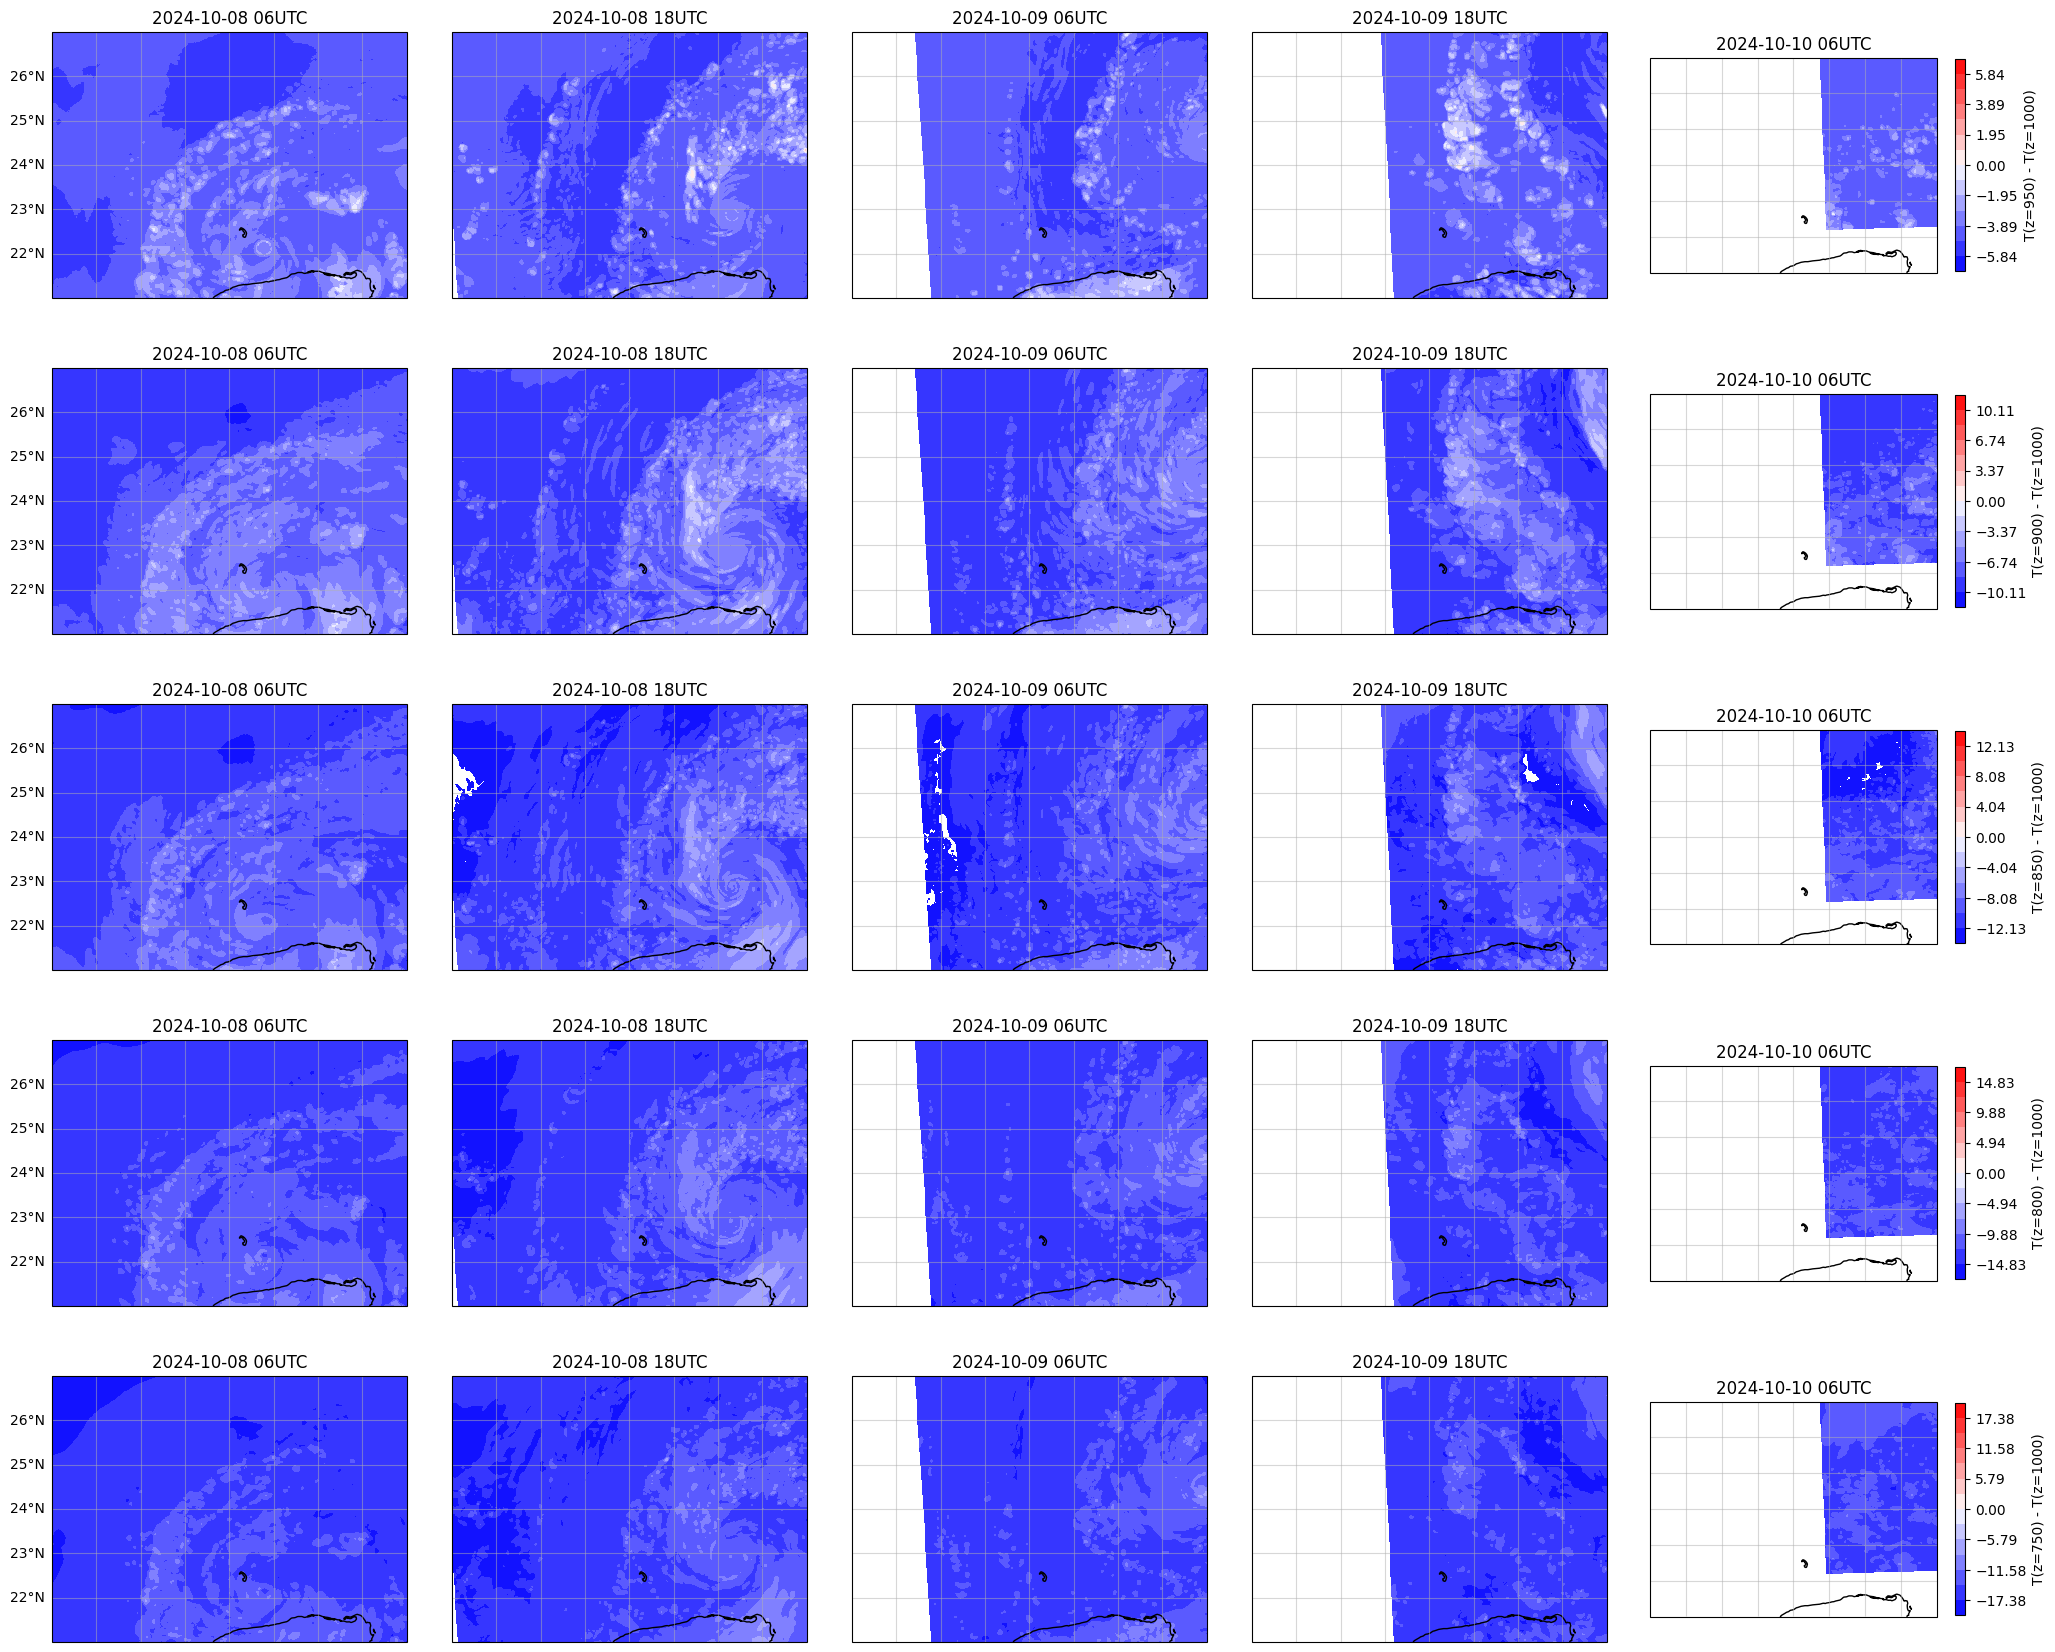

In [252]:
atmFig

In [ ]:
oceFig = plt.figure(figsize=(len(fcastTimes)*5,len(oceLayers)*7))
oceAxes = [[oceFig.add_axes([xcorner, ycorner, xWidth-buffer, yWidth-buffer], projection=ccrs.PlateCarree()) for ycorner in ycorners] for xcorner in xcorners]

In [ ]:
contourLevs = {layer:["Empty"] for layer in oceLayers}

for valid, oceAxColumn in zip(fcastTimes, oceAxes):

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  oceFile = "mom6_" + initStr + "_f" + fhour + ".nc"
  ocePath = dataPath + "mom6Output/" + subfolder + oceFile
  oceData = xr.open_dataset(ocePath, decode_times=False)

  upperLayers = {"top":[0]*len(oceLayers[:-1]), "incremental":oceLayers[:-1]}[diffType]
  for upperLayer, lowerLayer, oceAx in zip(upperLayers, oceLayers[1:], oceAxColumn):

    upperSlice = oceData.isel(z_l=upperLayer, time=0).sel(xh=slice(lonMin, lonMax), yh=slice(latMin, latMax))
    lowerSlice = oceData.isel(z_l=lowerLayer, time=0).sel(xh=slice(lonMin, lonMax), yh=slice(latMin, latMax))

    tdiff = upperSlice.temp.data - lowerSlice.temp.data

    maxContour = np.max(abs(tdiff[np.isnan(tdiff)==False]))+0.5
    if "Empty" in contourLevs[lowerLayer]: contourLevs[lowerLayer] = np.round(np.linspace(-maxContour, maxContour, 20), 2)

    #oceSlice = oceData.isel(z_l=oceLayer).sel(xh=slice(lonMin, lonMax), yh=slice(latMin, latMax), time=oceData.time.data[0]

    tempContour = oceAx.contourf(lowerSlice.xh.data, lowerSlice.yh.data, tdiff, cmap="bwr", transform=ccrs.PlateCarree(),
                                extent=[lonMin, lonMax, latMin, latMax], levels=contourLevs[lowerLayer])
    if valid == fcastTimes[-1]: oceFig.colorbar(tempContour, shrink=0.8, label=f"T(z={round(oceData.z_l.data[upperLayer],1)}) - T(z={round(oceData.z_l.data[lowerLayer],1)})")

    oceAx.scatter(tcLocs[valid][1], tcLocs[valid][0], marker="*", color="black", s=100, transform=ccrs.PlateCarree())

    gridLabels = []
    if lowerLayer == oceLayers[-1]: gridLabels.append("bottom")
    if valid == fcastTimes[0]: gridLabels.append("left")
    oceAx.gridlines(draw_labels=gridLabels, alpha=0.5)

    oceAx.add_feature(cft.COASTLINE)
    oceAx.add_feature(cft.BORDERS)
    oceAx.set_title(valid.strftime('%Y-%m-%d %HUTC'))

    oceAx.set_extent([lonMin, lonMax, latMin, latMax])

#oceFig.suptitle(f"Initialized {initTime.strftime('%Y-%m-%d %HUTC')}")

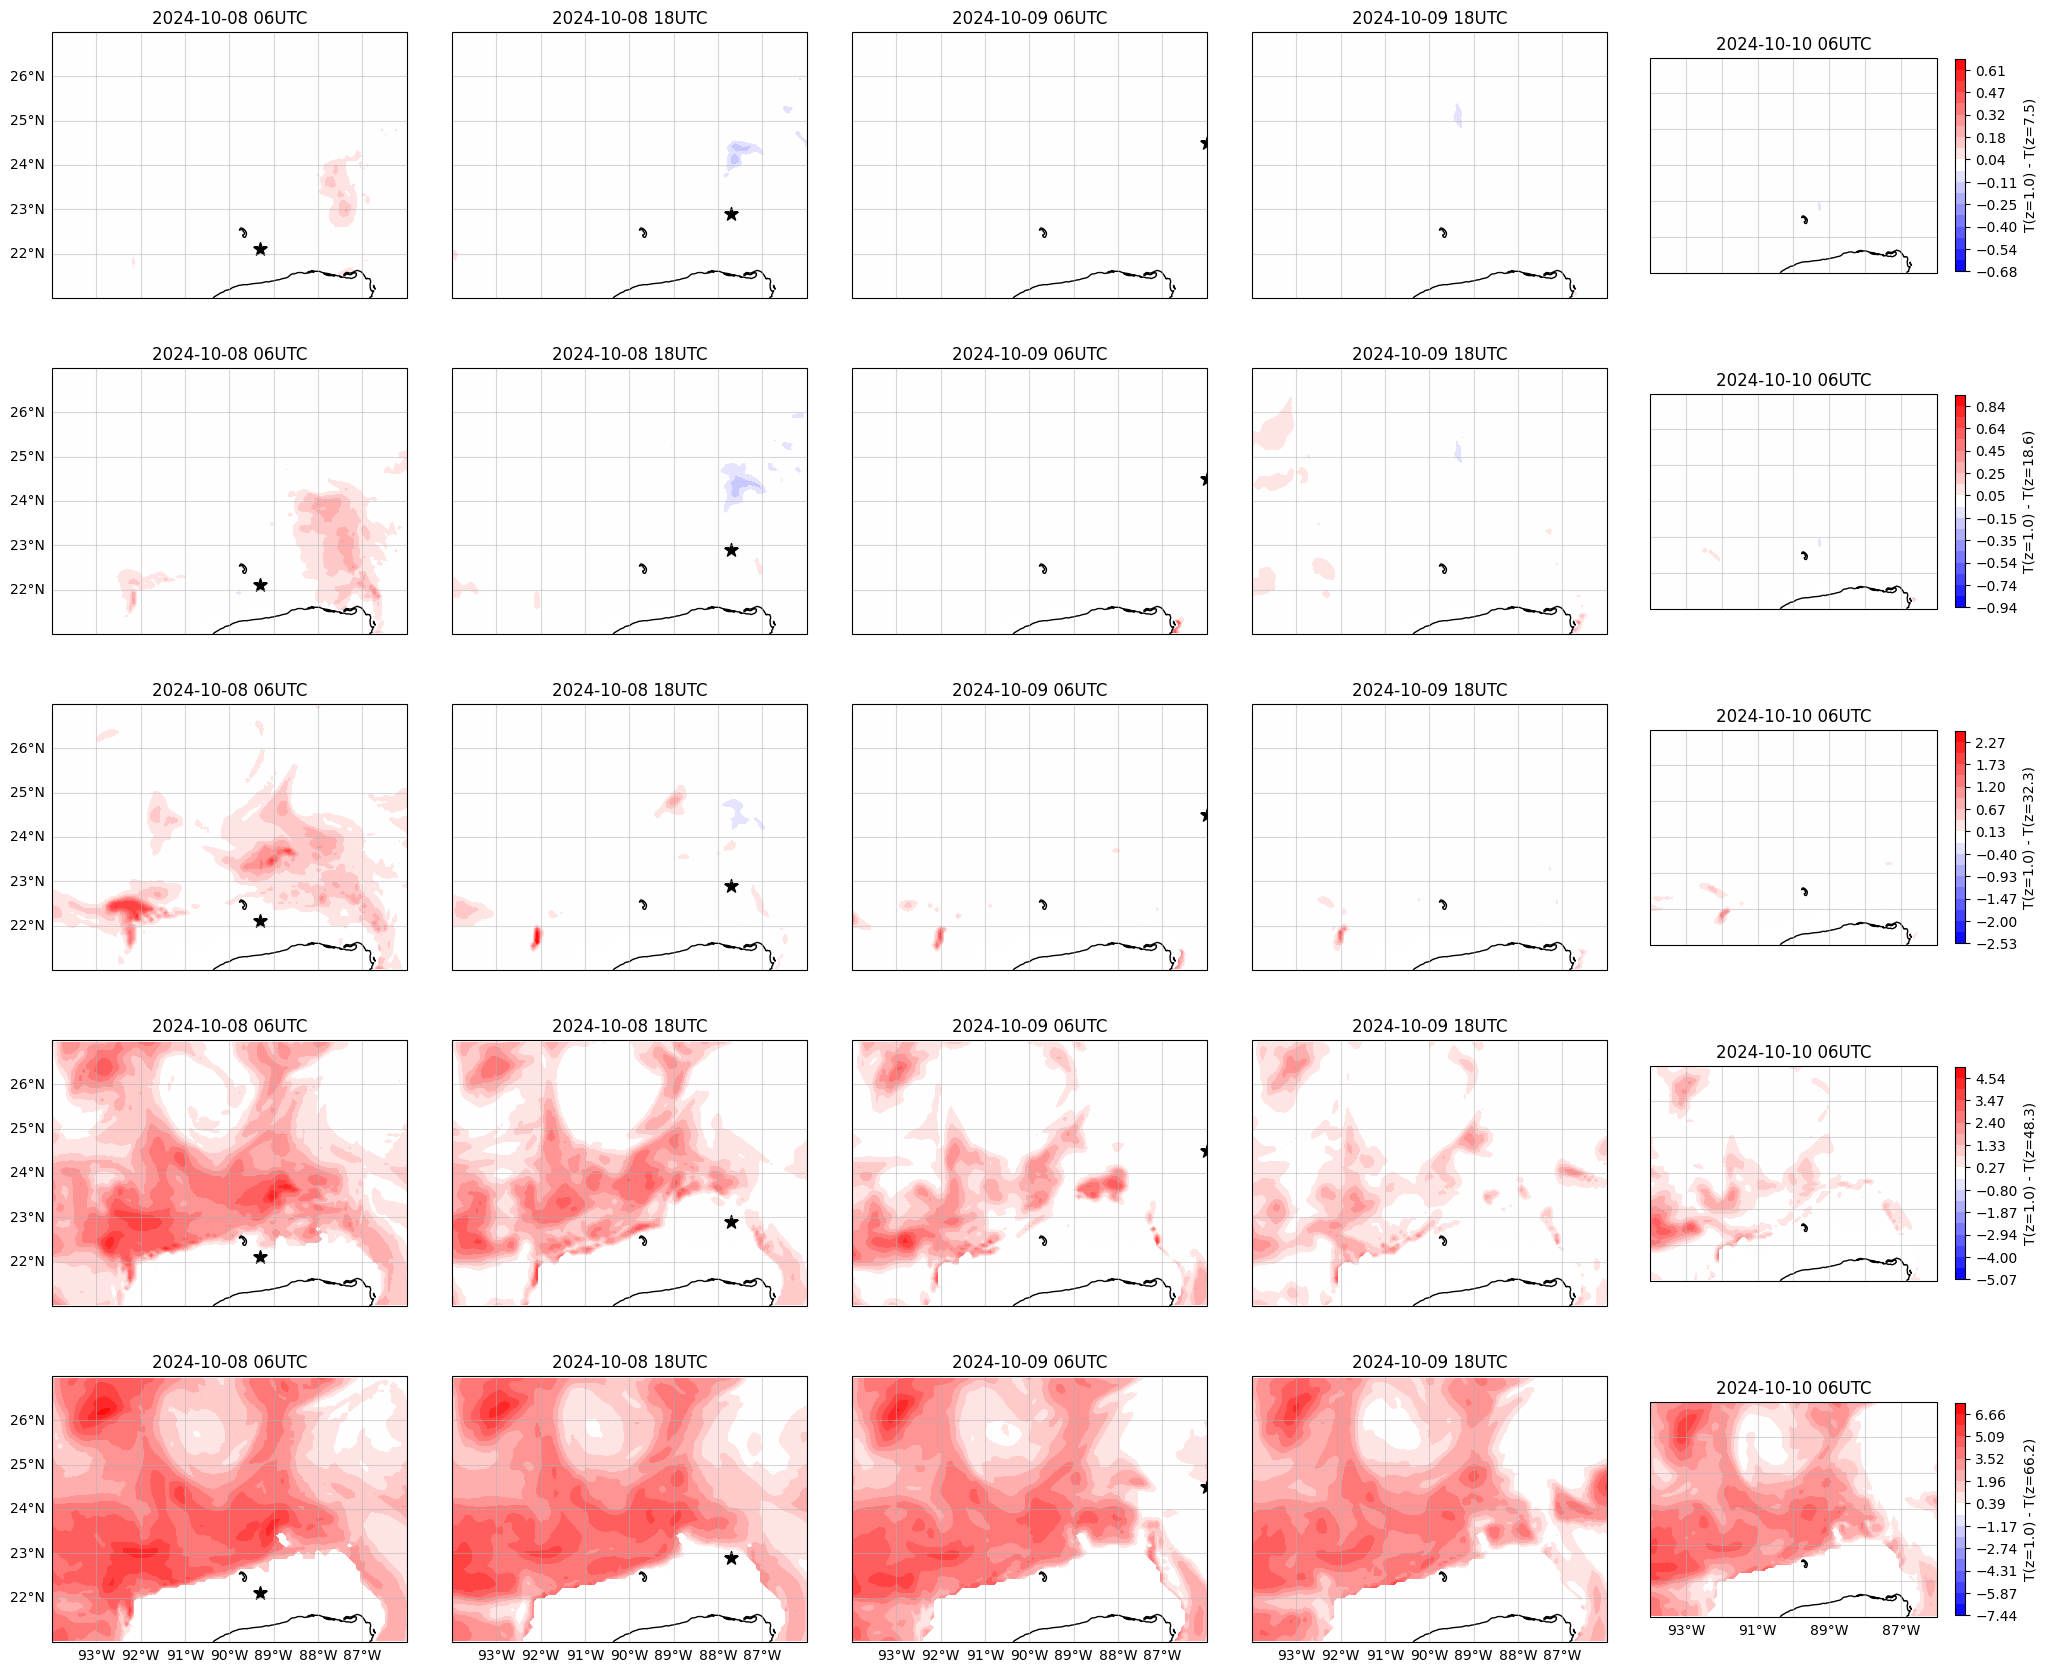

In [251]:
oceFig

Plot of Vertical Model Resolution

In [ ]:
resFig = plt.figure(figsize=(5, 8))
atmAx = resFig.add_axes([0.1, 0.55, 0.8, 0.4])
oceAx = resFig.add_axes([0.1, 0.05, 0.8, 0.4])

atmAx.plot(np.arange(0, len(atmData.isobaricInhPa.data)), atmData.isobaricInhPa.data, label="Atmosphere")
atmAx.scatter(np.arange(0, len(atmData.isobaricInhPa.data)), atmData.isobaricInhPa.data)

oceZ = oceData.z_l.data[oceData.z_l.data<=150]
oceAx.plot(np.arange(0, len(oceZ)), oceZ, label="Ocean")
oceAx.scatter(np.arange(0, len(oceZ)), oceZ)
oceAx.set_xticks(np.arange(0, len(oceZ), 3))

atmAx.grid(alpha=0.5)
atmAx.set_xlabel("# of Layers")
atmAx.set_ylabel("Pressure (hPa)")
atmAx.invert_yaxis()

oceAx.grid(alpha=0.5)
oceAx.set_xlabel("# of Layers")
oceAx.set_ylabel("Depth (m)")
oceAx.invert_yaxis()